In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential
from keras.utils.np_utils import to_categorical

## 2.1 Chuẩn bị dữ liệu

In [41]:
# đọc dữ liệu
df = pd.read_csv('/kaggle/input/news-aggregator/news+aggregator/newsCorpora.csv', sep='\t', encoding='utf-8', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
pd.set_option('display.max_columns', None)
df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [44]:
# 2 lọc dữ liệu theo tên Publisher
publisher = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
df = df[df['PUBLISHER'].isin(publisher)]
# 3 trộn dữ liệu, reset index, tách lấy cột CATEGORY và TITLE
df = df.sample(frac=1).reset_index(drop=True)
df = df[['CATEGORY', 'TITLE']]
df

,CATEGORY,TITLE
0,m,Parents warned phone addiction could damage bo...
1,t,UPDATE 1-US regulator reasserts goal to restri...
2,b,UPDATE 3-Thai economy shrinks more than expect...
3,b,Uber Drivers Face Criminal Case as Cabbies Try...
4,b,Airbnb Set to Challenge New York Rental Probe ...
...,...,...
13335,b,AT&T In Talks To Buy DirecTV For $50 Billion
13336,e,Jennifer Lawrence Knew You Were Going To Think...
13337,b,Swiss regulator says Credit Suisse management ...
13338,e,Lindsay Lohan - Lindsay Lohan won't speak to h...


In [9]:
# tạo thư mục lưu dữ liệu
!mkdir data

In [45]:
# 4 chia dữ liệu ra train test val
train = df[:int(len(df)*0.8)]
test = df[int(len(df)*0.8):int(len(df)*0.9)]
val = df[int(len(df)*0.9):]

test = test.reset_index(drop=True)
val = val.reset_index(drop=True)
# lưu data
train.to_csv('data/train.txt', sep='\t', index=False, header=True)
val.to_csv('data/val.txt', sep='\t', index=False, header=True)
test.to_csv('data/test.txt', sep='\t', index=False, header=True)

## 2.2 Khám phá dữ liệu

In [46]:
# show tổng số dữ liệu của từng class
df.CATEGORY.value_counts()

b    5627
e    5279
t    1524
m     910
Name: CATEGORY, dtype: int64

<AxesSubplot:xlabel='CATEGORY', ylabel='count'>

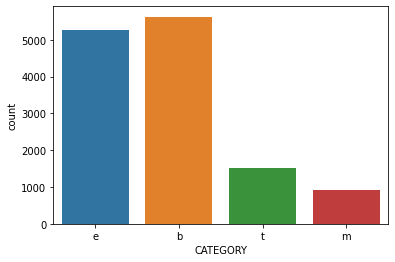

In [7]:
# vẽ biểu đồ cột
sns.countplot(x = 'CATEGORY',data = df)

### Thống kê trên tập train

In [94]:
# show tổng số dữ liệu của từng class của tập train
train_label_counts = train['CATEGORY'].value_counts()

# tìm mean max min
train['word_count'] = train['TITLE'].apply(lambda x: len(x.split()))
train_average_word_count = train['word_count'].mean()
train_max_word_count = train['word_count'].max()
train_min_word_count = train['word_count'].min()

print("Tổng số label:\n", train_label_counts)
print(f"\nSố từ trung bình: {train_average_word_count}")
print(f"Số từ lớn nhất: {train_max_word_count}")
print(f"Số từ nhỏ nhất: {train_min_word_count}")

Tổng số label:
 b    4507
e    4234
t    1209
m     722
Name: CATEGORY, dtype: int64

Số từ trung bình: 10.485476011994002
Số từ lớn nhất: 201
Số từ nhỏ nhất: 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Thống kê trên tập val

In [96]:
# show tổng số dữ liệu của từng class của tập val
val_label_counts = val['CATEGORY'].value_counts()

# tìm mean max min
val['word_count'] = val['TITLE'].apply(lambda x: len(x.split()))
val_average_word_count = val['word_count'].mean()
val_max_word_count = val['word_count'].max()
val_min_word_count = val['word_count'].min()

print("Tổng số label:\n", val_label_counts)
print(f"\nSố từ trung bình: {val_average_word_count}")
print(f"Số từ lớn nhất: {val_max_word_count}")
print(f"Số từ nhỏ nhất: {val_min_word_count}")

Tổng số label:
 b    562
e    506
t    174
m     92
Name: CATEGORY, dtype: int64

Số từ trung bình: 10.349325337331335
Số từ lớn nhất: 18
Số từ nhỏ nhất: 2


### Thống kê trên tập test

In [95]:
# show tổng số dữ liệu của từng class của tập test
test_label_counts = test['CATEGORY'].value_counts()

# tìm mean max min
test['word_count'] = test['TITLE'].apply(lambda x: len(x.split()))
test_average_word_count = test['word_count'].mean()
test_max_word_count = test['word_count'].max()
test_min_word_count = test['word_count'].min()

print("Tổng số label:\n", test_label_counts)
print(f"\nSố từ trung bình: {test_average_word_count}")
print(f"Số từ lớn nhất: {test_max_word_count}")
print(f"Số từ nhỏ nhất: {test_min_word_count}")

Tổng số label:
 b    558
e    539
t    141
m     96
Name: CATEGORY, dtype: int64

Số từ trung bình: 10.446026986506746
Số từ lớn nhất: 20
Số từ nhỏ nhất: 3


## 2.3 Huấn luyện mô hình

In [50]:
# tool để chuyển thành từ gốc
ps = PorterStemmer()

In [51]:
# làm sạch tập train
cleaned = []
for i in range(0,len(train)):
    
    # xóa kí tự không có trong bảng chữ cái
    msg = re.sub('[^a-zA-Z]',' ',train['TITLE'][i])
    
    # chuyển thành in thường
    msg = msg.lower()
    
    # tách câu thành list các từ
    msg = msg.split()
    
    # chuyển thành từ gốc
    msg = [ps.stem(words) for words in msg if not words in set(stopwords.words('english'))]
    msg = ' '.join(msg)
    cleaned.append(msg)

In [52]:
# làm sạch tập val
cleaned_val = []
for i in range(0,len(val)):
    msg = re.sub('[^a-zA-Z]',' ',val['TITLE'][i])
    msg = msg.lower()
    msg = msg.split()
    msg = [ps.stem(words) for words in msg if not words in set(stopwords.words('english'))]
    msg = ' '.join(msg)
    cleaned_val.append(msg)

In [53]:
# làm sạch tập test
cleaned_test = []
for i in range(0,len(test)):
    msg = re.sub('[^a-zA-Z]',' ',test['TITLE'][i])
    msg = msg.lower()
    msg = msg.split()
    msg = [ps.stem(words) for words in msg if not words in set(stopwords.words('english'))]
    msg = ' '.join(msg)
    cleaned_test.append(msg)

In [54]:
cleaned[:5]

['parent warn phone addict could damag bond child',
 'updat us regul reassert goal restrict verizon auction',
 'updat thai economi shrink expect q polit crisi may',
 'uber driver face crimin case cabbi tri block app',
 'airbnb set challeng new york rental probe subpoena']

In [55]:
cleaned_val[:5]

['funnyman brook wheelan fire snl one season',
 'yeah babi yeah lana del rey wear psychedel dress puff cigarett',
 'updat russia postpon launch new angara space rocket',
 'ecb draghi say euro zone recoveri proceed',
 'pharrel william pharrel william motiv wife']

In [56]:
cleaned_test[:5]

['mother outrag teenag boy dress girl ban wear',
 'updat honda other recal nearli mln vehicl air bag flaw',
 'ginnif goodwin wed co star josh dalla princess worthi wed',
 'juli th sing star spangl banner',
 'updat linkedin forecast strong qtr driven hire busi']

In [57]:
# 5000 từ thông dụng
dict_size = 5000

# encode
one_hot_mat = [one_hot(words,dict_size) for words in cleaned]
one_hot_mat_test = [one_hot(words,dict_size) for words in cleaned_test]
one_hot_mat_val = [one_hot(words,dict_size) for words in cleaned_val]

# padding cho input có cùng size, vì max word có nhiều nhất 201 từ nên maxlen = 201
embedded_layer = pad_sequences(one_hot_mat,padding = 'pre',maxlen = 201)
embedded_layer_test = pad_sequences(one_hot_mat_test,padding = 'pre',maxlen = 201)
embedded_layer_val = pad_sequences(one_hot_mat_val,padding = 'pre',maxlen = 201)
embedded_layer

array([[   0,    0,    0, ..., 3600,  546, 1626],
       [   0,    0,    0, ..., 1718, 1064, 1021],
       [   0,    0,    0, ..., 1583, 1506, 2656],
       ...,
       [   0,    0,    0, ..., 2413, 2970, 3436],
       [   0,    0,    0, ..., 3491, 3797, 1990],
       [   0,    0,    0, ..., 4867, 1488, 4127]], dtype=int32)

In [58]:
# tạo feature
x = embedded_layer
y = np.array(train['CATEGORY'])

x_test = embedded_layer_test
y_test = np.array(test['CATEGORY'])

x_val = embedded_layer_val
y_val = np.array(val['CATEGORY'])

In [59]:
# tạo one-hot vector cho label
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y,4)

y_test = le.fit_transform(y_test)
y_test = to_categorical(y_test,4)

y_val = le.fit_transform(y_val)
y_val = to_categorical(y_val,4)

In [60]:
y[:10]

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [98]:
# in ra shape của train test val
print(x.shape,y.shape)
print(x_test.shape,y_test.shape)
print(x_val.shape,y_val.shape)

(10672, 201) (10672, 4)
(1334, 201) (1334, 4)
(1334, 201) (1334, 4)


In [87]:
# tạo model LSTM cho text classification
model = Sequential()

# embedding dim = 50
model.add(Embedding(dict_size,50,input_length = len(x[0])))
model.add(Dropout(0.2))

# thêm layer LSTM
model.add(LSTM(100))

# tạo layer cuối
model.add(Dense(4,activation="softmax"))

# compile model
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

# in ra kiến trúc và tổng số param
model.summary()

# train model
rnn = model.fit(x, y, validation_data = (x_val,y_val), epochs = 10, batch_size = 256)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 201, 50)           250000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 201, 50)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 404       
Total params: 310,804
Trainable params: 310,804
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
42/42 [==============================] - 3s 36ms/step - loss: 1.2603 - accuracy: 0.4109 - val_loss: 1.0853 - val_accuracy: 0.7436
Epoch 2/10
42/42 [==============================] - 1s 25ms/step - loss: 0.9046 - accuracy: 0.7572 - val_

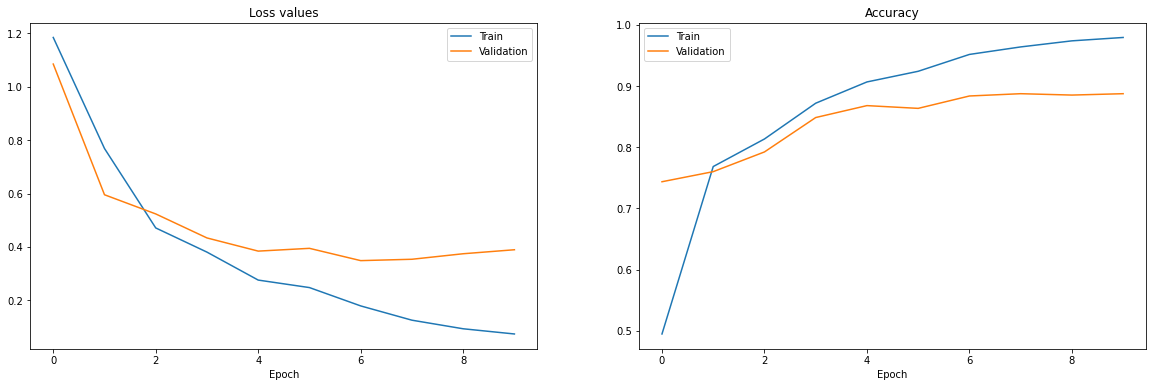

In [88]:
# vẽ loss và accuracy trong quá trình huấn luyện
plt.figure(figsize = (20, 6))

plt.subplot(121)
plt.title("Loss values")
plt.plot(rnn.history['loss'], label = 'Train')
plt.plot(rnn.history['val_loss'], label = 'Validation')
plt.xlabel("Epoch")
plt.legend()

plt.subplot(122)
plt.title("Accuracy")
plt.plot(rnn.history['accuracy'], label = 'Train')
plt.plot(rnn.history['val_accuracy'], label = 'Validation')
plt.xlabel("Epoch")
plt.legend()

In [102]:
# save model
model.save("model/model.h5")

## 2.4 Đánh giá mô hình

In [89]:
# đánh giá trên tập test
model.evaluate(x_test,y_test)

42/42 [==============================] - 0s 6ms/step - loss: 0.3783 - accuracy: 0.8981


[0.3782500922679901, 0.8980509638786316]

In [90]:
# predict trên tập test
pred = model.predict(x_test)

# chọn class có giá trị lớn nhất trên kqua predict
preds = []
for i in range(0,len(pred)):
    preds.append(pred[i].argmax())

# chọn class đúng
actual = []
for i in range(0,len(y_test)):
    actual.append(y_test[i].argmax())


In [91]:
# đánh giá tổng thể
from sklearn import metrics
report = metrics.classification_report(actual, preds, target_names = ['b','t','e','m'])
print(report)

              precision    recall  f1-score   support

           b       0.90      0.93      0.92       558
           t       0.94      0.93      0.93       539
           e       0.86      0.73      0.79        96
           m       0.75      0.74      0.75       141

    accuracy                           0.90      1334
   macro avg       0.86      0.83      0.85      1334
weighted avg       0.90      0.90      0.90      1334



In [93]:
# test thử.np_utils
txt = ["An apple a day keeps doctor away."]

# tiền xử lí dữ liệu
cleaned = []
for i in range(0,len(txt)):
    msg = re.sub('[^a-zA-Z]',' ',txt[i])
    msg = msg.lower()
    msg = msg.split()
    msg = [ps.stem(words) for words in msg if not words in set(stopwords.words('english'))]
    msg = ' '.join(msg)
    cleaned.append(msg)

one_hot_mat = [one_hot(words,dict_size) for words in cleaned]
embedded_layer = pad_sequences(one_hot_mat,padding = 'pre',maxlen = 201)
embedded_layer

# predict
pred = model.predict(embedded_layer)
cat = ['Business','Science','Entertainment','Health']
print(pred, cat[np.argmax(pred)])

[[0.02187982 0.00934649 0.11376159 0.8550122 ]] Health
